# Introduction

Hi there! 🙋‍♂️

This goal of this project is to be able to build a convolutional neural network (**CNN**) which will do multi-class image classification. The CNN that is built is not from scratch, but actually leveraging **transfer learning** from an existing **ResNet152** CNN to do this multi-class image classification against breeds of dogs. 

The data set I've chosen is the Stanford Dogs dataset where there are over 20,000 images of dogs. Within those 20,000 images, there are 120 different breeds.

The goal is to be able to fine-tune the ResNet152 CNN in such a way that given a new image of a dog, the CNN can infer which specific breed of dog the image may represent.

# Disclaimer
Please be aware of the following:

* I am new at this AI space. My experience: 3 months of studying on and off after my day job and dad duties.
* I am still learning Python and its ecosystem tooling and libraries

So if there is anything questionable in this guide, or you feel can be done better, please, I always welcome feedback.

I do try to do the right things though. Thankfully there are tons of good resources out there which I have utilized to try and "do the right thing".

# Acquire the Dataset

The first step in our journey to create this CNN is to acquire the dataset to be used for training, and test.

Retrieve the dataset here: [http://vision.stanford.edu/aditya86/ImageNetDogs/](http://vision.stanford.edu/aditya86/ImageNetDogs/)

We are interested in downloading the images and annotation file. 

The direct links to the compressed archives are found here:

* Images - [http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar](http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar)
* Annotations - [http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar](http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar)

For background reading, the paper is a nice and short introduction to the dataset: [https://people.csail.mit.edu/khosla/papers/fgvc2011.pdf](https://people.csail.mit.edu/khosla/papers/fgvc2011.pdf)

It confirms a few things about the dataset:

* 120 dog breeds
* 20,580 images
* ~180 images per class
  
An important thing to know about this dataset is that visibility of the dog varies in the images. Sometimes, a dog can be partially occluded by another subject such as a human. Bounding boxes are given to determine where the dog is in the image, and this is an important detail for later. But this is an interesting detail as it can provide a bit of "flavor" in our training set. 

# Tech Stack

As a computer enthusiast, I always enjoy knowing about the physical tools and software to build something In order to satisfy that enthusiast tendency, I'll also detail the system I used to train. I didn't use any cloud services as I wanted to learn how the software stack is actually configured to do AI development.

The hardware I run is pretty high end. It is actually a gaming PC which I've recently repurposed to do exploration in AI. Here are my basic desktop specifics:

* CPU - Intel Core i9 12900K (8P/8E/24T)
* RAM - 128 GB DDR4 3200
* SSD - 2TB Samsung 990 Pro NVMe
* GPU - NVIDIA RTX 4090
* OS - Windows 11 Pro with WSL2

The hardware itself is very nice, and is pretty much overkill for most people. It just barely is enough for me though. 😅

As for the software side of things, the code was written using:
* Jupyter Lab (using standard IPython Kernel)
* Tensorflow 2.13.0
* All the latest NVIDIA CUDA and machine learning drivers and libraries (look at the step by step guide referenced later for specifics)

It was actually pretty tricky to get Tensorflow running with my GPU on Windows. I did not know that after version 2.10, Tensorflow stopped supporting GPU learning on native Windows. As a result, I had to try to figure out how to make it work with WSL2, and it wasn't all too smooth.

WSL2 is basically a Linux environment on top of Windows (think of it as pretty much a VM). With WSL2, we can actually install our development environment within it and get Tensorflow running with the GPU as now it is technically within a Linux environment.

The drawback of using WSL2 is that I've found its default installation has really bad disk I/O. Disk reads and writes just felt very slow. I can certainly tweak this but I really wanted to get the project working, so I decided to tolerate it for a bit.

Note once more that Linux and macOS do not have this problem. If I was to do this project again, I would first reconfigure my computer to use Linux (maybe Pop!_OS) and go from there. Afterall, my new life now is AI! AI, AI, AI! 🙈

Okay, so for anyone having trouble on Windows, follow these two guides to get unblocked!

* [Microsoft Learn - Install WSL2](https://learn.microsoft.com/en-us/windows/wsl/install)
* [Tensorflow Step-by-Step Installation Guide for WSL2](https://www.tensorflow.org/install/pip#windows-wsl2)

Once `tensorflow` is installed, then we can proceed with the rest of the setup steps.

The following libraries are necessary:

* `pillow` (for image manipulation)
* `numpy` (to help with array manipulation)
* `matplotlib` (showing some charts)

We can install it with the following command:

In [ ]:
pip install pillow numpy matplotlib scikit-learn pandas --user

# Getting Familiar with the Data

The nice thing about tensorflow is that it already provides us with a lot of built-in tools get our data in a good shape. The dataset itself is already organized well! ✅

First, unzip the files downloaded from the internet with the following similar folder structure. I've decided to place these files in a folder called `dataset` in the same directory of the project. 

For example, my file structure looks like this: 
```
/
|__ CNN_project.ipynb
|__ dataset/
    |__ Images/
        |__ n02085620-Chihuahua/
            |__ n02085620_7.jpg
            |__ ...
            |__ n02085620_14516.jpg
        |__ ...
        |__ n02116738-African_hunting_dog/
            |__ n02116738_124.jpg
            |__ ...
            |__ n02116738_10895.jpg
    |__ Annotation/
        |__ n02085620-Chihuahua
            |__ n02085620_7
            |__ ...
            |__ n02085620_14516
        |__ ...
        |__ n02116738-African_hunting_dog/
            |__ n02116738_124
            |__ ...
            |__ n02116738_10895
```

Each folder in `Images` is actually scoped to a specific breed of dog. And within the subfolder of `Images` of that breed, there are the corresponding images. With that type of structure, it is not necessary to perform any sort of operation in the Images folder relating to the file system. This means we don't need to move the images out to "flatten" directory structure to preprocess or anything. The Images folder is in the right structure, a nice **120 folders** -- a folder for each class. 😉

The `Annotations` folder also includes all the metadata for that specific image, including the filename, dimensions of the image, name of breed, and the bounding box at which where the dog is placed within the image. All this is very useful in our quest to prepare the data.

The file structure for Annotations is similar to the Images folder. Therefore, I will not explain too much there. Instead, let us take a look at a sample file for a **Chihuahua**:

```xml
<annotation>
	<folder>02085620</folder>
	<filename>n02085620_382</filename>
	<source>
		<database>ImageNet database</database>
	</source>
	<size>
		<width>500</width>
		<height>375</height>
		<depth>3</depth>
	</size>
	<segment>0</segment>
	<object>
		<name>Chihuahua</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>134</xmin>
			<ymin>24</ymin>
			<xmax>361</xmax>
			<ymax>373</ymax>
		</bndbox>
	</object>
</annotation>
```

Here are some interesting properties:

* `filename` is the corresponding JPG image file
* `width` and height of the image. 
* `name` is the "class" of the dog
* `bndbox` - This is the bounding box where the dog is located in `x` and `y` coordinates within the image. 

# Inspecting the Data
Let's take 5 random files (manually chosen) and see what they look like. We just define the `images_path` to be the base path, and specify the relative locations in Images for the image file names.

Then we use the `Image` module in `pillow` to load the image into memory and call show to display it.

Here is what we get:

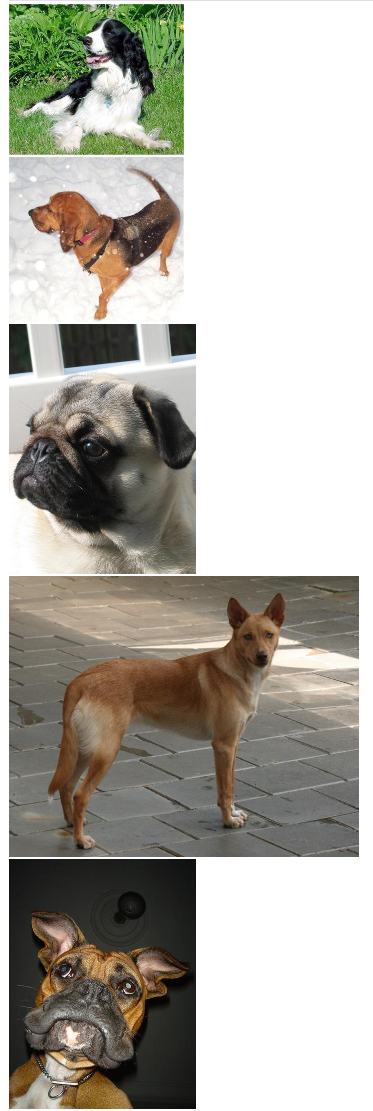

Notice here each image is of different size and each dog is photographed at a different angle.

In [ ]:
from PIL import Image

images_path = "./dataset/Images/"

samples = [
    f"{images_path}n02085782-Japanese_spaniel/n02085782_381.jpg",
    f"{images_path}n02088466-bloodhound/n02088466_2908.jpg",
    f"{images_path}n02110958-pug/n02110958_353.jpg",
    f"{images_path}n02115641-dingo/n02115641_670.jpg",
    f"{images_path}n02108089-boxer/n02108089_922.jpg"
]

for sample_image_file in samples:
    with Image.open(sample_image_file) as im:
        display(im)

## Preprocess the Images

In order to ensure some good results, I've decided to make use of the `bndbox` property in each annotations file. For every image we will utilize the `xmin`, `ymin`, `xmax`, and `ymax` properties to crop out the dogs in the image and ensure that at best we have most of the dog available in the image to classify the breed.

Again, utilizing the `Image` module, we can easily use `crop` and `save` to the same directory, overwriting the original with the cropped version of the image that should only consist of the dogs.

Now, after doing that we can get the same image, but now in cropped form to the bounding box.

We use `xml.etree.ElementTree` to do the heavy lifting for the XML parsing.

In [ ]:
from PIL import Image
import numpy as np
import pickle
import os
import shutil
import xml.etree.ElementTree as ET

images_path = "./dataset/Images/"
annotation_path = "./dataset/Annotation/"

annotations_filepath_data = os.walk(annotation_path)
images_filepath_data = os.walk(images_path)

The next block of code is pretty complicated, but in short, it just does the image cropping by walking through all the annotation files, gathering up the image file names, bounding box and dog names to perform the crop.

In [ ]:
'''
Helper to get the bounding box coordinates. 
It is assumed that the bndbox node is valid and has valid coordinates.
'''
def get_bounding_box_coordinates(root_node):
    bndbox = root_node.find('./object/bndbox')
    
    xmin = float(bndbox.find('./xmin').text)
    ymin = float(bndbox.find('./ymin').text)
    xmax = float(bndbox.find('./xmax').text)
    ymax = float(bndbox.find('./ymax').text)

    return xmin, ymin, xmax, ymax

'''
Helper to get the image file name.
If the image file name does not exist, we fall back and use the corresponding
image file found in the Images/ directory.
'''
def get_image_file_name(root_node):
    image_file_name = annotation_root.find('./filename')

    real_image_file_name = f"{image_file_name.text}.jpg"
    if real_image_file_name != f"{annotation_file_name}":
        real_image_file_name = f"{annotation_file_name}.jpg"

    return real_image_file_name

'''
Helper to get the dog name (class).
'''
def get_dog_name(root_node):
    dog_name_node = root_node.find('./object/name')

    return dog_name_node.text

for fda in annotations_filepath_data:
    a_dirpath, a_dirnames, a_filenames = fda

    for annotation_dir_name in a_dirnames:
        current_annotation_dir = f"{a_dirpath}{annotation_dir_name}"
        annotations_file_filepath_data = os.walk(current_annotation_dir)
        
        for fdaf in annotations_file_filepath_data:
            af_dirpath, af_dirnames, af_filenames = fdaf
            
            for annotation_file_name in af_filenames:
                full_annotation_path = f"{current_annotation_dir}/{annotation_file_name}"
                base_path = '/'.join(full_annotation_path.replace(f"/Annotation/", "/Images/").split(sep='/')[:-1])

                # Parse the "XML" file into nodes
                annotation_tree = ET.parse(full_annotation_path)
                annotation_root = annotation_tree.getroot() 
        
                real_image_file_name = get_image_file_name(annotation_root)
                xmin, ymin, xmax, ymax = get_bounding_box_coordinates(annotation_root)
                dog_name = get_dog_name(annotation_root)
                
                full_image_path = f"{base_path}/{real_image_file_name}"
                with Image.open(full_image_path) as im:
                    # Crop the image to only contain the dog
                    im_cropped = im.crop((xmin, ymin, xmax, ymax))

                    # Make sure it is an RGB file
                    im_cropped = im_cropped.convert('RGB')
                    im_cropped.save(full_image_path, 'JPEG')

print("Done.")

After doing the crop, we can take a look at the images again by executing the same code to display our example images. 

Here is what is displayed. Notice the images are slightly smaller now.

In [ ]:
from PIL import Image

images_path = "./dataset/Images/"

samples = [
    f"{images_path}n02085782-Japanese_spaniel/n02085782_381.jpg",
    f"{images_path}n02088466-bloodhound/n02088466_2908.jpg",
    f"{images_path}n02110958-pug/n02110958_353.jpg",
    f"{images_path}n02115641-dingo/n02115641_670.jpg",
    f"{images_path}n02108089-boxer/n02108089_922.jpg"
]

for sample_image_file in samples:
    with Image.open(sample_image_file) as im:
        display(im)

# Training with Tensorflow

I had a lot of problems here since I was not very experienced with `tensorflow`. Remember, I am still only a beginner. 😅

First thing to do is configure the GPU. I am not yet sure why this happens, but I have a lot of memory issues when attempting to train with my GPU. Of course, it is most likely my batch size for my given neural network architecture, but I've even tried small batches, and I seem to run out of memory. Maybe it is a WSL2 thing. This is why I recommend just going with Linux. 🙂 

Anyway, all I need to do to prevent an OOM (out of memory) error is to just hard-limit the amount of GPU memory (VRAM) which tensorflow can use during training. Since the RTX 4090 has 24GB VRAM, I just allocate 20GB. There is no real reason why I chose 20GB. It was purely emprical from my various struggles.

We also import a bunch of tensorflow libraries and set the logging level to be `ERROR` - I only want the errors to be logged during the training process.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_input_resnet152V2

import logging

tf.get_logger().setLevel(logging.ERROR)

gpus = tf.config.list_physical_devices('GPU')

if (len(gpus) > 0):
    tf.config.set_logical_device_configuration(gpus[0],[tf.config.LogicalDeviceConfiguration(memory_limit=20480)])

# Prepare the Training and Test Datasets

Remember how I was pretty clear about not messing around the folder structure for the `Images` part of the dataset? 😁 Yes, because we can just readily use it as is to generate the data structure of all the training and test batches for our model!
We can take advantage of `ImageDataGenerator` and its `flow_from_directory` API method to actually create the training and test batches of images in a manner which allows us to split the training/test data set in specific ratios.

I highly recommend reading some of this basic documentation here: [https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

And yes, I am aware that ImageDataGenerator is depcrecated! My goal is to reinforce learning in this project, so it is worth to just take the path of least trouble and use what works. 

I had trouble actually getting a significant validation accuracy score during my training because I did not really know how to use the specific functionality. 

I decided between a **70/30** split between the training dataset and test dataset. 

We don't need to standardize the data here as we pass in the available `preprocess_input_mnet function` to the `preprocessing_function` argument. This allows our pixel data to scale with what ResNet152 expects -- which is in the `-1` to `1` range.

Also notice that in the grand scheme of things, 20,000 images for 120 breeds of dogs may not be enough. We can augment image data during training on the fly by generating variations of the image. Here, I specify the training set to have also random horizontal flipping and small random rotations. This can get me additional data to train on. (This is good practice to do when performing this type of work with not much data). 

When using `flow_from_directory`, we just need to consider interpretation of the truth values in training set to be categorical, so the values can be one-hot encoded vectors. We also explicitly specify shuffle to be True as to make sure the data is randomized. 
The dimensions I decide to use here is **224x224** as that is seemingly the standard approach for these types of CNNs. 

A note on the `batch_size`. For whatever reason, I always had a really bad `val_accuracy` whenever my batch_size was small. By "small" I really mean stuff like the default number of 32. I noticed that as I increased `batch_size`, the `val_accuracy` got better. I searched the internet one day to see who else may have encountered the problem 

[https://stackoverflow.com/questions/52251199/low-validation-accuracy-with-good-training-accuracy-keras-imagedatagenerator-f](https://stackoverflow.com/questions/52251199/low-validation-accuracy-with-good-training-accuracy-keras-imagedatagenerator-f)

Toren from this StackOverflow page also had the same issue. I tried the same by setting the batch size to 120, and my training results suddenly got better! For some reason, results were even better once I increased batch size to 160. It didn't seem to get much better at 192, or above though. So this is how I came to decide that **160** would be the batch_size for this particular model.

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

images_path = "./dataset/Images/"

images_dir = images_path

train_gen = ImageDataGenerator(validation_split=0.3, preprocessing_function=preprocess_input_resnet152V2, horizontal_flip=True, rotation_range=10 )
v_gen = ImageDataGenerator(validation_split=0.3, preprocessing_function=preprocess_input_resnet152V2)

X_train_i = train_gen.flow_from_directory(images_dir, target_size=(224, 224), color_mode='rgb', batch_size=160, class_mode='categorical', subset='training', shuffle=True, seed=1337)
X_test_i = v_gen.flow_from_directory(images_dir, target_size=(224, 224), color_mode='rgb', batch_size=160, class_mode='categorical', subset='validation', shuffle=True, seed=1337)

print('Number of training batches:', len(X_train_i))
print('Number of test batches:', len(X_test_i))

# Define the Neural Network Architecture

Now it is time to define the neural network architecture. As this is a form of transfer learning, I am taking the base model of the **ResNet152** CNN and adapting it to learn how to classify dog breeds.

The helpful article from Keras about transfer learning helped me understand how to do this. It is a good read here: [https://keras.io/guides/transfer_learning/#transfer-learning-amp-finetuning](https://keras.io/guides/transfer_learning/#transfer-learning-amp-finetuning)

Basically, what I am doing here is instantiating the **ResNet152** model as my "base model" by assigning it to `base_model`. I create an overall model and add the `base_model` as the first layer. 
From here, I want to get a 1D representation of the units so I call `Flatten` to reduce the CNN output to be used with my own `Dense` layer of 1024 units using ReLU activation.

From my experimentation adding dropout regularization of 20% seems to get good results with this layer.

Finally, I use `softmax` on the last layer with 120 units. Each unit represents the predicted result of the 120 breeds. Since it is a softmax activation, it should be expected that each value in the vector represents a specific probability mapped to the label at that position.

When it comes to learning rate, I had some trouble determining the best learning rate. I found that `1e-4` works best using the `Adam` optimizer. 

In [ ]:
# Adjust the learning rate for experimentation.
LEARNING_RATE = 1e-4

base_model = ResNet152V2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(120, activation='softmax'))

'''
Lock down the base ResNet152 model. We do not want to lose its learned parameters for
detecting some useful features!
'''
model.layers[0].trainable = False

adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

# Training the Model

Training the model is the longest part. It takes about over a minute for each epoch on my computer. I think that is fast. 🤔 

Anyway, it is pretty straightforward here. I followed the fit API in Keras Model object. 

When it comes to determining the amount of epochs to run the training for, I actually ran this many times over and found that 20 was a good number. The model with ResNet was already very good. So pretty much the only job here is to get it to learn how to classify the dogs. In other words, it doesn't need to learn how to identify basic features like eyes, and others.

Here is a sample log output over time:
```
91/91 [==============================] - 70s 704ms/step - loss: 1.4377 - accuracy: 0.6748 - val_loss: 0.7209 - val_accuracy: 0.8032
Epoch 2/20
91/91 [==============================] - 63s 692ms/step - loss: 0.4978 - accuracy: 0.8580 - val_loss: 0.7129 - val_accuracy: 0.8166
Epoch 3/20
91/91 [==============================] - 63s 693ms/step - loss: 0.3454 - accuracy: 0.8992 - val_loss: 0.7600 - val_accuracy: 0.8099
Epoch 4/20
91/91 [==============================] - 63s 690ms/step - loss: 0.2636 - accuracy: 0.9229 - val_loss: 0.7444 - val_accuracy: 0.8238
Epoch 5/20
91/91 [==============================] - 63s 690ms/step - loss: 0.2023 - accuracy: 0.9386 - val_loss: 0.7430 - val_accuracy: 0.8259
Epoch 6/20
91/91 [==============================] - 63s 693ms/step - loss: 0.1664 - accuracy: 0.9474 - val_loss: 0.7920 - val_accuracy: 0.8290
Epoch 7/20
91/91 [==============================] - 63s 694ms/step - loss: 0.1317 - accuracy: 0.9593 - val_loss: 0.8305 - val_accuracy: 0.8269
Epoch 8/20
91/91 [==============================] - 63s 693ms/step - loss: 0.1238 - accuracy: 0.9645 - val_loss: 0.7956 - val_accuracy: 0.8331
Epoch 9/20
91/91 [==============================] - 63s 690ms/step - loss: 0.1076 - accuracy: 0.9668 - val_loss: 0.9230 - val_accuracy: 0.8277
Epoch 10/20
91/91 [==============================] - 63s 688ms/step - loss: 0.1066 - accuracy: 0.9683 - val_loss: 0.9214 - val_accuracy: 0.8295
Epoch 11/20
91/91 [==============================] - 63s 692ms/step - loss: 0.0849 - accuracy: 0.9752 - val_loss: 0.9249 - val_accuracy: 0.8277
Epoch 12/20
91/91 [==============================] - 63s 696ms/step - loss: 0.0836 - accuracy: 0.9739 - val_loss: 0.9788 - val_accuracy: 0.8267
Epoch 13/20
91/91 [==============================] - 63s 695ms/step - loss: 0.0869 - accuracy: 0.9751 - val_loss: 1.0085 - val_accuracy: 0.8247
Epoch 14/20
91/91 [==============================] - 63s 693ms/step - loss: 0.0834 - accuracy: 0.9766 - val_loss: 1.0100 - val_accuracy: 0.8278
Epoch 15/20
91/91 [==============================] - 63s 694ms/step - loss: 0.0881 - accuracy: 0.9759 - val_loss: 1.0704 - val_accuracy: 0.8277
Epoch 16/20
91/91 [==============================] - 63s 693ms/step - loss: 0.0706 - accuracy: 0.9789 - val_loss: 1.0348 - val_accuracy: 0.8265
Epoch 17/20
91/91 [==============================] - 63s 691ms/step - loss: 0.0715 - accuracy: 0.9805 - val_loss: 1.0682 - val_accuracy: 0.8275
Epoch 18/20
91/91 [==============================] - 63s 693ms/step - loss: 0.0686 - accuracy: 0.9806 - val_loss: 1.0951 - val_accuracy: 0.8272
Epoch 19/20
91/91 [==============================] - 63s 690ms/step - loss: 0.0635 - accuracy: 0.9833 - val_loss: 1.1134 - val_accuracy: 0.8273
Epoch 20/20
91/91 [==============================] - 63s 690ms/step - loss: 0.0679 - accuracy: 0.9814 - val_loss: 1.0870 - val_accuracy: 0.8329
```

In [ ]:
# About 20 EPOCHS is all that is needed here
EPOCHS = 20
BATCH_SIZE = 120

first_history = model.fit(X_train_i, validation_data=X_test_i, epochs=EPOCHS, steps_per_epoch=len(X_train_i), batch_size=BATCH_SIZE, validation_steps=len(X_test_i), shuffle=True)

# Analyzing the Results

After training, notice that we can achieve pretty good accuracy on our test data. With the run shown above, it can be around 83% for this particular dataset.

Let's inspect the history and plot the accuracy between training and validation. As we will see, the model was already good to begin with, and our job was really just to help it learn how to classify 120 breeds of dogs. 🤯

In [ ]:
first_history.history

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

accuracy_history = first_history.history['accuracy']
val_accuracy_history = first_history.history['val_accuracy']

x_epochs = np.arange(stop=len(accuracy_history))

plt.plot(x_epochs, accuracy_history, label='Training accuracy')
plt.plot(x_epochs, val_accuracy_history, label='Validation accuracy')
plt.legend()
plt.title('Learning history')

# Saving the Model

Before moving forward, I want to save my model! Such hard work so far! It would be disappointing to lose my new dog classifying AI! We will also reload it immediately just for the sake of testing to see if saving went well.

In [ ]:
# now save what we have just trained. It is precious...
model.save('./dog_breed_model.keras')

In [ ]:
# Reload it
model = tf.keras.models.load_model('./dog_breed_model.keras')

# Predicting!

Now it is time to try out our model! First, I have created 2 helper functions. get_labels which extracts and processes the various breeds from the classes available. Then predict is the main function that takes in a filename of the image of choice and returns back a dictionary of 3 possible dog breeds with their probability. 

After that it's as simple as just changing filename to your image of choice.

In [ ]:
from PIL import Image

def get_labels():
    mapping = X_train_i.class_indices

    labels = mapping.keys()

    reverse_mapping = {}
    for label in labels:
        reverse_mapping[mapping[label]] = ''.join(label.split('-')[1:]) \
            .replace('_', ' ') \
            .lower()

    return reverse_mapping
    
def predict(filename):
    with Image.open(filename) as im:
        # Prepare the image
        im = im.resize((224, 224))
        processed = np.array(preprocess_input_resnet152V2(np.array(im)))
        processed = processed.reshape((1, 224, 224, 3))

        # Predict
        result = model.predict(x=[processed])

        # Get top 3 results
        categories_map = get_labels()
        top_3_values = tf.nn.top_k(result[0], k=3, sorted=True).values.numpy()
        top_3_indices = tf.nn.top_k(result[0], k=3, sorted=True).indices.numpy()

        results_map = {}
        j = 0
        for idx in top_3_indices:
            label = categories_map[idx]
            results_map[label] = top_3_values[j]
            j += 1

        return results_map

In [ ]:
# Point this to the image of your dog!
filename = './test_images/norfolk_terrier.jpg'

print('Top 3 possible breeds with probability for', filename)
predict(filename)

# Conclusion
This was a really difficult project for me to work on. There were many struggles for me. The main struggles came from not fully understanding transfer learning until I read the Keras article.

At first, I was trying train the model from scratch, not using any pre-trained models. I was very surprised by the low accuracy! Then I realized it was better to use an existing CNN. There were a few I tried out, but ultimately settled on ResNet152.

1. VGG16
2. ResNet50
3. MobileNet

From multiple rounds of training **ResNet152** was the best. 

Learning how to pre-process input was tricky too. I wasn't aware to actually pre-process each image. I had run into low-accuracy issues because I didn't realize I did not need to renormalize the image to divide by `255.0`. It was simply sufficient to just use the preprocessing functions provided by the model's library.

Figuring out the learning rate to get a decent result was also challenging. I ran 1e-3, 1e-4, 1e-5, but come to be happy with 1e-4.

Overall, I am happy with the results. I am able to test various dog images and have had good success in classifying the dog breeds. 🐶

Thanks for sticking around!